<h1>CNN model on GAMEEMO raw dataset, 7 secs grouping</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


<h3>Helper functions to plot loss/accuracy, and build/train/test models.</h3>

In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
def build_model(sample_size, num_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_conv_layers:",len(conv_layers_filters_array))    
    for i, conv_layer_filters in enumerate(conv_layers_filters_array):       
        print("conv_layer_filters["+str(i)+"]; unit:"+str(conv_layer_filters))  
        print("conv_kernel["+str(i)+"]; unit:"+str(conv_kernel_size_array[i]))
        print("conv_strides["+str(i)+"]; unit:"+str(conv_strides_array[i]))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Dense layers
        for i, conv_layer_filters in enumerate(conv_layers_filters_array):    
            model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_filters,                
            kernel_size=conv_kernel_size_array[i],
            strides=conv_strides_array[i],
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i),
            activation='relu'))
        
            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2,
                name='pool_'+str(i))) 

        if len(conv_layers_filters_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, sample_size, num_of_features))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(sample_size, num_of_features,
                         train_dataset, validate_dataset, x_train, test_dataset,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(sample_size, num_of_features,
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        conv_layers_filters_array=conv_layers_filters_array,
                        conv_kernel_size_array=conv_kernel_size_array,
                        conv_strides_array=conv_strides_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))


In [5]:
# dataset = pd.read_csv('csv/out_gameemo_time_domain_simple.csv',  sep=',')

# print('Shape of data: ', dataset.shape)

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

path="dataset_gameemo/original_data_with_timestamps"
dirs = os.listdir(path)

X_7_sec = []
y = []

num_of_features = 14
num_of_records_per_experiment=37632
num_of_samples = 42
sample_size=int(num_of_records_per_experiment/num_of_samples)

for file in dirs:
    df = pd.read_csv('dataset_gameemo/original_data_with_timestamps/' + file)
    df.drop(columns='timestamps', inplace=True)
    list_of_arrays = np.array_split(df[:num_of_records_per_experiment],num_of_samples)
    for array in list_of_arrays:
        X_7_sec.append(array)
        category = str(file)[4]
        y.append(label_map[int(category)])
X_7_sec = np.array(X_7_sec)
# y = np.array([int(cat)-1 for cat in y])

X_train, X_validate, y_train, y_validate = train_test_split(X_7_sec, y, train_size=0.6, random_state=0)
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=0)


y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train.shape:", y_train.shape)
print("y_validate.shape:", y_validate.shape)
print("y_test.shape:", y_test.shape)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

batch_size = 30
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


y_train.shape: (2822, 4)
y_validate.shape: (941, 4)
y_test.shape: (941, 4)
y_train:
   HA_NV  HA_PV  LA_NV  LA_PV
0      0      0      0      1
1      1      0      0      0
2      0      1      0      0
3      1      0      0      0
4      0      0      1      0


<h3>Manual runs to get a feel of the hyperparameters</h3>

Test on the best CNN+MLPNN model trained on features dataset with 88.82 test accuracy.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loca

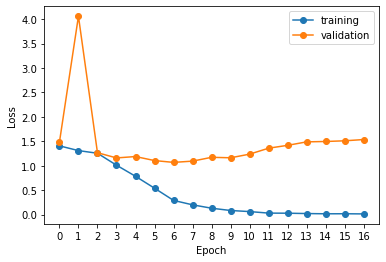

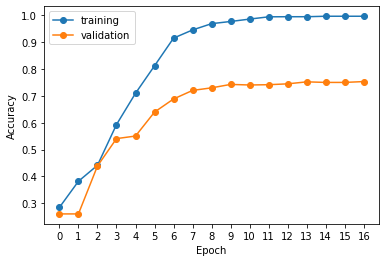

32/32 [==============================] - 0s 6ms/step - loss: 1.4294 - accuracy: 0.7407 - precision: 0.7525 - recall: 0.7269

Test Acc. 74.07%
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       236
           1       0.79      0.78      0.78       240
           2       0.73      0.77      0.75       239
           3       0.75      0.71      0.73       226

   micro avg       0.74      0.74      0.74       941
   macro avg       0.74      0.74      0.74       941
weighted avg       0.74      0.74      0.74       941
 samples avg       0.74      0.74      0.74       941

Confusion matrix
[[167  24  24  21]
 [ 35 186   9  10]
 [ 23  10 183  23]
 [ 16  16  33 161]]


In [7]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
num_of_conv_layers: 1
conv_layer_filters[0]; unit:1024
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 896, 1024)         44032     
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 448, 1024)         0         
_________________________________________________________________
flatten (Flatten)          

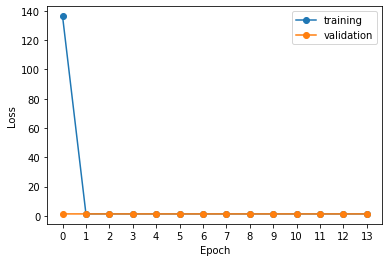

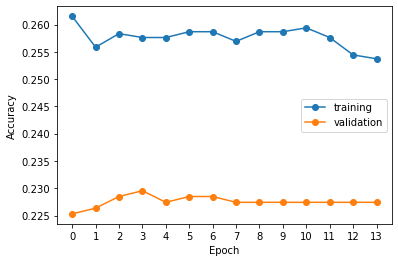

32/32 [==============================] - 0s 10ms/step - loss: 1.3867 - accuracy: 0.2497 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 24.97%
              precision    recall  f1-score   support

           0       0.25      1.00      0.40       236
           1       0.00      0.00      0.00       240
           2       0.00      0.00      0.00       239
           3       0.00      0.00      0.00       226

   micro avg       0.25      0.25      0.25       941
   macro avg       0.06      0.25      0.10       941
weighted avg       0.06      0.25      0.10       941
 samples avg       0.25      0.25      0.25       941

Confusion matrix
[[235   0   0   1]
 [240   0   0   0]
 [239   0   0   0]
 [225   1   0   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[1024],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 896, 14)           56        
_________________________________________________________________
conv_0

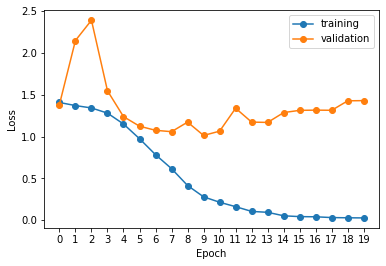

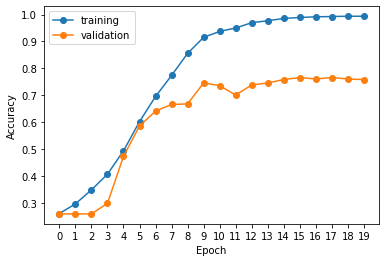

32/32 [==============================] - 0s 6ms/step - loss: 1.3608 - accuracy: 0.7407 - precision: 0.7492 - recall: 0.7333

Test Acc. 74.07%
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       236
           1       0.75      0.77      0.76       240
           2       0.76      0.72      0.74       239
           3       0.76      0.76      0.76       226

   micro avg       0.74      0.74      0.74       941
   macro avg       0.74      0.74      0.74       941
weighted avg       0.74      0.74      0.74       941
 samples avg       0.74      0.74      0.74       941

Confusion matrix
[[169  32  20  15]
 [ 31 184  13  12]
 [ 26  14 173  26]
 [ 16  16  23 171]]


In [10]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 896, 14)           56        
_________________________________________________________________
conv_0 (Conv1D)              

95/95 [==============================] - 1s 14ms/step - loss: 1.3382 - accuracy: 0.3565 - precision: 0.6919 - recall: 0.0031 - val_loss: 1.3649 - val_accuracy: 0.3496 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 25/40
95/95 [==============================] - 1s 14ms/step - loss: 1.3451 - accuracy: 0.3499 - precision: 0.7869 - recall: 0.0042 - val_loss: 1.3647 - val_accuracy: 0.3486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 26/40
95/95 [==============================] - 1s 14ms/step - loss: 1.3325 - accuracy: 0.3590 - precision: 0.6553 - recall: 0.0030 - val_loss: 1.3646 - val_accuracy: 0.3486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 27/40
95/95 [==============================] - 1s 14ms/step - loss: 1.3356 - accuracy: 0.3469 - precision: 0.7310 - recall: 0.0018 - val_loss: 1.3644 - val_accuracy: 0.3486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 28/40
95/95 [==============================] - 1s 14ms/step - loss: 1.3321 - a

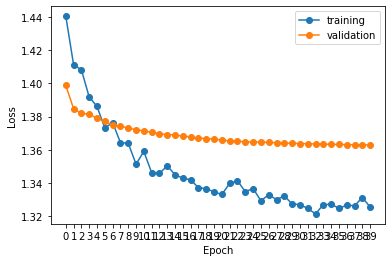

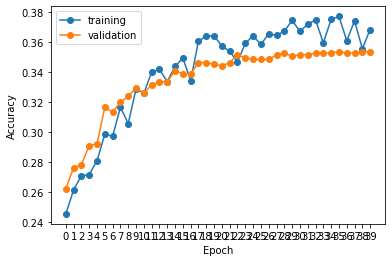

32/32 [==============================] - 0s 6ms/step - loss: 1.3617 - accuracy: 0.3241 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Acc. 32.41%
              precision    recall  f1-score   support

           0       0.29      0.34      0.31       236
           1       0.32      0.35      0.34       240
           2       0.40      0.28      0.33       239
           3       0.31      0.33      0.32       226

   micro avg       0.32      0.32      0.32       941
   macro avg       0.33      0.32      0.32       941
weighted avg       0.33      0.32      0.32       941
 samples avg       0.32      0.32      0.32       941

Confusion matrix
[[80 74 31 51]
 [63 85 31 61]
 [69 53 66 51]
 [61 52 39 74]]


In [11]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.001,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 4
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
conv_layer_filters[3]; unit:100
conv_kernel[3]; unit:3
conv_strides[3]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 896, 14)           56        
__________________

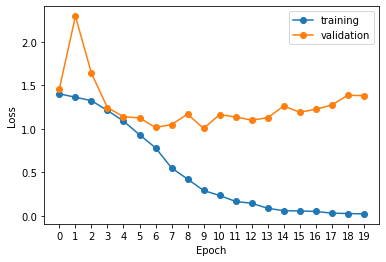

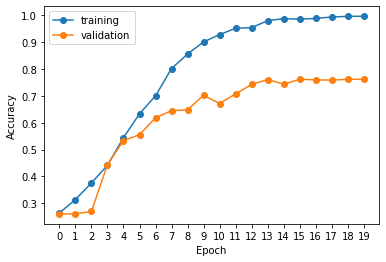

32/32 [==============================] - 0s 6ms/step - loss: 1.3163 - accuracy: 0.7598 - precision: 0.7772 - recall: 0.7524

Test Acc. 75.98%
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       236
           1       0.76      0.80      0.78       240
           2       0.76      0.77      0.76       239
           3       0.78      0.75      0.76       226

   micro avg       0.76      0.76      0.76       941
   macro avg       0.76      0.76      0.76       941
weighted avg       0.76      0.76      0.76       941
 samples avg       0.76      0.76      0.76       941

Confusion matrix
[[170  29  23  14]
 [ 26 192   9  13]
 [ 18  17 184  20]
 [ 14  16  27 169]]


In [12]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100,100],
                     conv_kernel_size_array=[3,3,3,3],
                     conv_strides_array=[1,1,1,1]
                    )

<h3>Conclusion</h3>

Using the best CNN+MLPNN model on features dataset, for raw dataset it yields 74.07% accuracy </br>

Manual Tuning: 75.98% </br>
num_of_dense_layers: 1 </br>
dense_layer[0]; unit:512 </br>
num_of_conv_layers: 4 </br>
conv_layer_filters[0]; unit:100 </br>
conv_kernel[0]; unit:3 </br>
conv_strides[0]; unit:1 </br>
conv_layer_filters[1]; unit:100 </br>
conv_kernel[1]; unit:3 </br>
conv_strides[1]; unit:1 </br>
conv_layer_filters[2]; unit:100 </br>
conv_kernel[2]; unit:3 </br>
conv_strides[2]; unit:1 </br>
conv_layer_filters[3]; unit:100 </br>
conv_kernel[3]; unit:3 </br>
conv_strides[3]; unit:1 </br>
learningRate: 0.1 </br>
isBatchNormalized: False </br>
dropOutRate: 0.5 </br>
startWithBatchNormalized: True </br>
optimizer: SGD </br>
activation: relu </br>

